# Библиотеки

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from datetime import datetime
from google.colab import drive
from keras.models import load_model
import h5py
import os
import math
from keras import backend as K
from keras.models import Model, Input
from keras.initializers import RandomNormal
from keras.layers import Conv2D, Conv2DTranspose, LeakyReLU, Activation, Concatenate, Dropout, BatchNormalization

# Загрузка данных

## Подключение к Google Drive

In [ ]:
DATA_PATH = '/content/drive/MyDrive/Data/'

## Создание датасета

In [ ]:
def dataUpload(file_name, IMG_WIGHT, IMG_HEIGHT, IMG_CHANNELS):
  """
  Input: полный путь к файлу с изображениями в формате hdf5, ширину, высоту, кол-во каналов
  Do: загружает изображения и сохраняет их numpy массиве 
  Output: датасет вида (кол-во изображений, ширина, высота, кол-во каналов)
  """
  res = []

  with h5py.File(file_name, 'r') as f: 
    def print_attrs(name):
      t = name.split('/')
      temp = ''
      for i in range(len(t)-1):
        temp += t[i]
        if not (temp in res):
          res.append(temp)

    f.visit(print_attrs)

  if res:
      path = input(f"Выберите какие файлы загрузить: {res}\n")
      with h5py.File(file_name, 'r') as f: 
        KeysList = list(f[path].keys())
        output = np.zeros((len(KeysList), IMG_HEIGHT, IMG_WIGHT, IMG_CHANNELS), dtype=np.float32)

        for i in range(len(KeysList)):
          data = np.array(f[f'{path}/{KeysList[i]}'])
          output[i] = np.reshape(data, (IMG_WIGHT,IMG_HEIGHT,IMG_CHANNELS))

  else:
      with h5py.File(file_name, 'r') as f: 
        KeysList = list(f.keys())
        output = np.zeros((len(KeysList), IMG_HEIGHT, IMG_WIGHT, IMG_CHANNELS), dtype=np.float32)

        for i in range(len(KeysList)):
          data = np.array(f[f'{KeysList[i]}'])
          output[i] = np.reshape(data, (IMG_WIGHT,IMG_HEIGHT,IMG_CHANNELS))

  return(output)

In [ ]:
# добавление шумов
def addNoise(dset):
  return dset+np.random.randint(-0.1*dset.min(), 0.1*dset.max(), dset.shape)

# Отрисовка даных

In [ ]:
def plotExamples(dset, n_samp=3):
  """
  Input: numpy массив с изображениями вида (кол-во изображений, ширина, высота, кол-во каналов), кол-во изображений для отрисовки
  Do: в случайном порядке выбирает изображения из датасета и отрисовывает их
  Output: ничего
  """
  examples = np.random.randint(len(X_train[0]), size=n_samp)

  plt.figure(figsize=(20, 20), dpi=80)

  for i, n in enumerate(examples):
    plt.subplot(2, n_samp, n_samp+1+i)
    plt.axis('off')
    plt.imshow(dset[n, :, :, 0])
  plt.show()

# Стандартизация данных

In [ ]:
def standart(dset, dataMean=None, dataStd=None):
  """
  Input: numpy массив с изображениями вида (кол-во изображений, ширина, высота, кол-во каналов), 
  среднее значение пикселей и стандартное отклонение, если необходимо стандартизировать по уже имеющимся данным
  Do: при необходимости расчитывает среднее значение пикселей и стандартное отклонение,
  вычитает попиксельно среднее значение и делит на стандартное отклонение,
  печатает среднее значение пикселей и стандартное отклонение после стандартизации
  Output: numpy массив с изображениями вида (кол-во изображений, ширина, высота, кол-во каналов), 
  среднее значение пикселей и стандартное отклонение
  """
  if not (dataMean) or not (dataStd):
    dataMean = dset.mean()
    dataStd = np.std(dset)

  dset = (dset - dataMean)/dataStd

  print('Mean: ', dset.mean(), 'Std: ', np.std(dset))

  return dset, dataMean, dataStd

In [ ]:
def destandart(dset, dataMean, dataStd):
  """
  Input: numpy массив с изображениями вида (кол-во изображений, ширина, высота, кол-во каналов), 
  среднее значение пикселей и стандартное отклонение
  Do: умножает попиксельно на стандартное отклонение и прибавляет среднее значение, 
  которые были поданы (берутся те значения, котрые получились при стандартизации),
  печатает среднее значение пикселей и стандартное отклонение после дестандартизации
  Output: numpy массив с изображениями вида (кол-во изображений, ширина, высота, кол-во каналов), 
  среднее значение пикселей и стандартное отклонение
  """
  dset = dset*dataStd + dataMean

  print('Mean: ', dset.mean(), 'Std: ', np.std(dset))

  return dset

# Нормализация данных

In [ ]:
def norm(dset, bit=14):
  """
  Input: numpy массив с изображениями вида (кол-во изображений, ширина, высота, кол-во каналов), 
  при необходимости разрядность детектора
  Do: делит попиксельно на 2 в степени разрядности детектора
  Output: numpy массив с изображениями вида (кол-во изображений, ширина, высота, кол-во каналов)
  """
  dset = dset/2**bit

  return dset

In [ ]:
def denorm(dset, bit=14):
  """
  Input: numpy массив с изображениями вида (кол-во изображений, ширина, высота, кол-во каналов), 
  при необходимости разрядность детектора
  Do: умножает попиксельно на 2 в степени разрядности детектора
  Output: numpy массив с изображениями вида (кол-во изображений, ширина, высота, кол-во каналов)
  """
  dset = dset*2**bit

  return dset

# Модель

## Дискриминатор

In [ ]:
def discriminator(image_shape):
  """
  Создает модель дискриминатора
  """

  init = RandomNormal(stddev=0.02)

  in_src_image = Input(shape=image_shape) # Изображение, которое хотим преобразовать
  in_target_image = Input(shape=image_shape) # Изображение, которое хотим получить

  merged = Concatenate()([in_src_image, in_target_image])

  d = Conv2D(64, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init,)(merged)
  d = LeakyReLU(alpha=0.2)(d)

  d = Conv2D(128, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init,)(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)

  d = Conv2D(256, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init,)(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)

  d = Conv2D(512, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init,)(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)

  d = Conv2D(512, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init,)(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)

  d = Conv2D(1, (4, 4), padding='same', kernel_initializer=init)(d)
  patch_out = Activation('sigmoid')(d)

  model = Model([in_src_image, in_target_image], patch_out)
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=optimizer, loss_weights=[0.5])

  return model

## Генератор

In [ ]:
def encoder_block(layer_in, n_filters, batchnorm=True):
  """
  Блок энкодера в генераторе
  """

  init = RandomNormal(stddev=0.02)

  g = Conv2D(n_filters, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(layer_in)

  if batchnorm:
    g = BatchNormalization()(g, training=True)

  g = LeakyReLU(alpha=0.2)(g)

  return g

In [ ]:
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
  """
  Блок декодера в генераторе
  """
  init = RandomNormal(stddev=0.2)

  g = Conv2DTranspose(n_filters, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(layer_in)
  g = BatchNormalization()(g, training=True)

  if dropout:
    g = Dropout(0.3)(g, training=True)

  g = Concatenate()([g, skip_in])

  g = Activation('relu')(g)

  return g

In [ ]:
def generator(image_shape=(256, 256, 3)):
  """
  Создает модель из блоков, определенных выше
  """
  init = RandomNormal(stddev=0.02)

  in_image = Input(shape=image_shape)

  e1 = encoder_block(in_image, 64, batchnorm=False)
  e2 = encoder_block(e1, 128)
  e3 = encoder_block(e2, 256)
  e4 = encoder_block(e3, 512)
  e5 = encoder_block(e4, 512)
  e6 = encoder_block(e5, 512)
  e7 = encoder_block(e6, 512)

  b = Conv2D(512, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(e7)
  b = Activation('relu')(b)

  d1 = decoder_block(b, e7, 512)
  d2 = decoder_block(d1, e6, 512)
  d3 = decoder_block(d2, e5, 512)
  d4 = decoder_block(d3, e4, 512, dropout=False)
  d5 = decoder_block(d4, e3, 256, dropout=False)
  d6 = decoder_block(d5, e2, 128, dropout=False)
  d7 = decoder_block(d6, e1, 64, dropout=False)

  g = Conv2DTranspose(image_shape[2], (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(d7)
  # out_image = Activation('sigmoid')(g)
  # out_image = Activation('tanh')(g)
  # out_image = LeakyReLU(alpha=0.2)(g)

  model = Model(in_image, g)

  return model

## GAN

In [ ]:
def gan(g_model, d_model, image_shape):
  """
  Создает GAN модель из дискриминатора и генератора 
  """
  for layer in d_model.layers:
    if not isinstance(layer, BatchNormalization):
      layer.trainable = False

  in_src = Input(shape=image_shape)
  gen_out = g_model(in_src)
  dis_out = d_model([in_src, gen_out])

  optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
  model = Model(in_src, [dis_out, gen_out])
  model.compile(loss=['binary_crossentropy','mae'], optimizer=optimizer, loss_weights=[1, 5000])

  return model

# Функции для обучения

## Генерация образцов для обучения

In [ ]:
def generate_real_samples(TrainA, TrainB, n_samples, patch_shape):
  """
  Берет случайные пары элементов из датасетов обучения и помечает их единицами
  """
  n = np.random.randint(0, TrainA.shape[0], n_samples)
  x1, x2 = TrainA[n], TrainB[n]
  y = np.ones((n_samples, patch_shape, patch_shape, 1))
  return [x1, x2], y

In [ ]:
def generate_fake_samples(g_model, samples, patch_shape):
  """
  Создает при помощи генератора образцы и помечает их нулями
  """
  x = g_model.predict(samples)
  y = np.zeros((len(x), patch_shape, patch_shape, 1))
  return x, y

## Функция обучения

In [ ]:
def train(d_model, g_model, gan_model, trainA, trainB, n_epochs=100, n_batch=1):
	n_patch = d_model.output_shape[1]
	bat_per_epo = int(len(trainA) / n_batch)
	n_steps = bat_per_epo * n_epochs
	d_loss_hist = []
	g_loss_hist = []

	for i in range(n_steps):
		[X_realA, X_realB], y_real = generate_real_samples(trainA, trainB, n_batch, n_patch)
		X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
		d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
		d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
		g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
	
		d_loss_hist.append((d_loss2+d_loss2)/2)
		g_loss_hist.append(g_loss)
	
		print('>%d/%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, n_steps, d_loss1, d_loss2, g_loss))
	
		if (i+1) % (bat_per_epo * 50) == 0:
			summarize_performance(i, g_model, trainA, trainB)
	 
	return d_loss_hist, g_loss_hist

## Итоги обучения и сохранение модели

In [ ]:
def summarize_performance(step, g_model, TrainA, TrainB, n_samples=3):
	[X_realA, X_realB], _ = generate_real_samples(TrainA, TrainB, n_samples, 1)
	X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)	

	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + i)
		plt.axis('off')
		plt.imshow(X_realA[i, :, :, 0])

	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + n_samples + i)
		plt.axis('off')
		plt.imshow(X_fakeB[i, :, :, 0])

	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + n_samples*2 + i)
		plt.axis('off')
		plt.imshow(X_realB[i, :, :, 0])

	filename1 = 'plot_%06d.png' % (step+1)
	plt.savefig(filename1)
	plt.close()
 	
	# opt = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
	# g_model.compile(loss = [PSNR], optimizer=opt)
	# g_model.evaluate(X_train[:10], Y_train[:10])

	filename2 = 'model_%06d.h5' % (step+1) # Сохранение модели генератора
	optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
	g_model.compile(loss=['binary_crossentropy', 'mae'], optimizer=optimizer, loss_weights=[1, 5000])
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

# Loss функции

## PSNR

In [ ]:
def PSNR(y_true, y_pred):
    max_pixel = max(y_true.max(), y_pred.max())
    return 10.0 * (1.0 / math.log(10)) * K.log((max_pixel ** 2) / (K.mean(K.square(y_pred - y_true))))

## SSIM

In [ ]:
def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 2.0))

# Обучение GAN

In [ ]:
# вводим константы
IMG_WIGHT = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 1
image_shape = (IMG_WIGHT,IMG_HEIGHT,IMG_CHANNELS)

In [ ]:
# загружаем тренировочные данные
X_train = addNoise(dataUpload(DATA_PATH+'centr_256.hdf5', IMG_WIGHT, IMG_HEIGHT, IMG_CHANNELS))
Y_train = dataUpload(DATA_PATH+'centr_256.hdf5', IMG_WIGHT, IMG_HEIGHT, IMG_CHANNELS)

Выберите какие файлы загрузить: ['data', 'empty']
empty
Выберите какие файлы загрузить: ['data', 'empty']
empty


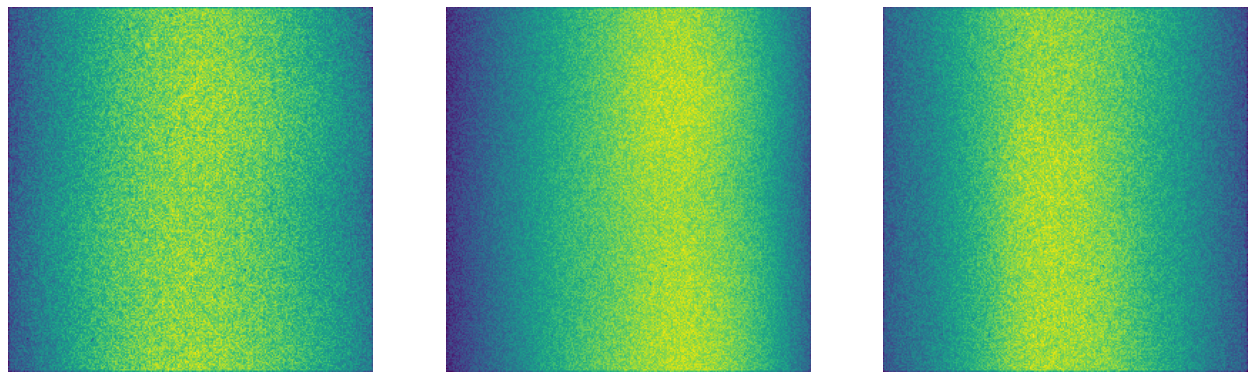

In [ ]:
# смотрим на тренировчные данные
plotExamples(X_train, n_samp=3)

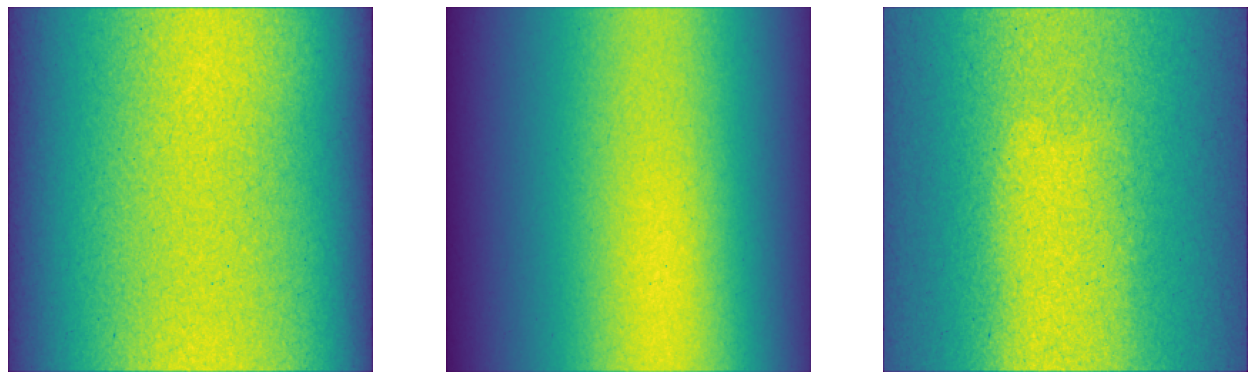

In [ ]:
# смотрим на тренировчные данные
plotExamples(Y_train, n_samp=3)

In [ ]:
# стандартизируем изображения
X_train, dataMean, dataStd = standart(X_train)
Y_train, _, _ = standart(Y_train, dataMean=dataMean, dataStd=dataStd)

NameError: ignored

In [ ]:
# нормализуем изображения
X_train = norm(X_train, bit=12)
Y_train= norm(Y_train, bit=12)

In [ ]:
# предобучение генератора на парах: изображение с шумом - пустой пучок
prelearned_model = generator((IMG_WIGHT, IMG_HEIGHT, IMG_CHANNELS))
opt = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
]

prelearned_model.compile(optimizer=opt, loss=[ssim_loss, 'mse'], metrics=[ssim_loss, 'mse'])
prelearned_model.fit(Y_train, Y_train, validation_split = 0.2, batch_size=128, epochs=300, callbacks=[my_callbacks])

Epoch 1/300
2/2 [==============================] - 48s 18s/step - loss: 0.9983 - ssim_loss: 0.9963 - mse: 0.2191 - val_loss: 0.9434 - val_ssim_loss: 0.9434 - val_mse: 0.2145
Epoch 2/300
2/2 [==============================] - 3s 2s/step - loss: 0.9194 - ssim_loss: 0.9157 - mse: 0.2034 - val_loss: 0.8266 - val_ssim_loss: 0.8266 - val_mse: 0.1876
Epoch 3/300
2/2 [==============================] - 3s 2s/step - loss: 0.7969 - ssim_loss: 0.7953 - mse: 0.1787 - val_loss: 0.7142 - val_ssim_loss: 0.7142 - val_mse: 0.1707
Epoch 4/300
2/2 [==============================] - 3s 2s/step - loss: 0.6818 - ssim_loss: 0.6788 - mse: 0.1638 - val_loss: 0.6376 - val_ssim_loss: 0.6376 - val_mse: 0.1545
Epoch 5/300
2/2 [==============================] - 3s 2s/step - loss: 0.5967 - ssim_loss: 0.5931 - mse: 0.1479 - val_loss: 0.5353 - val_ssim_loss: 0.5353 - val_mse: 0.1394
Epoch 6/300
2/2 [==============================] - 3s 2s/step - loss: 0.5078 - ssim_loss: 0.5071 - mse: 0.1331 - val_loss: 0.4879 - val_ss

In [ ]:
# создаем новый датасет из пар: изображение с объектом - пустой пучок
X_train = dataUpload(DATA_PATH+'centr_256.hdf5', IMG_WIGHT, IMG_HEIGHT, IMG_CHANNELS)
Y_train = dataUpload(DATA_PATH+'centr_256.hdf5', IMG_WIGHT, IMG_HEIGHT, IMG_CHANNELS)

Выберите какие файлы загрузить: ['data', 'empty']
data
Выберите какие файлы загрузить: ['data', 'empty']
empty


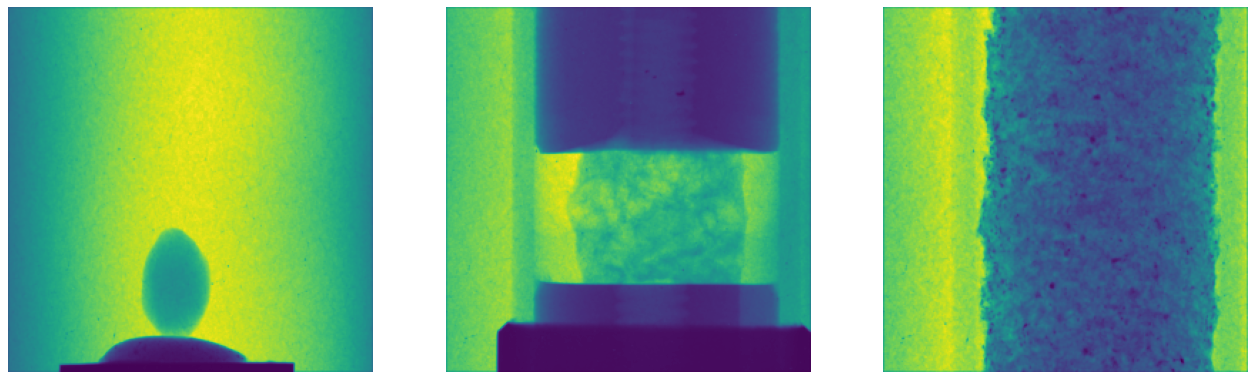

In [ ]:
# смотрим на тренировчные данные
plotExamples(X_train, n_samp=3)

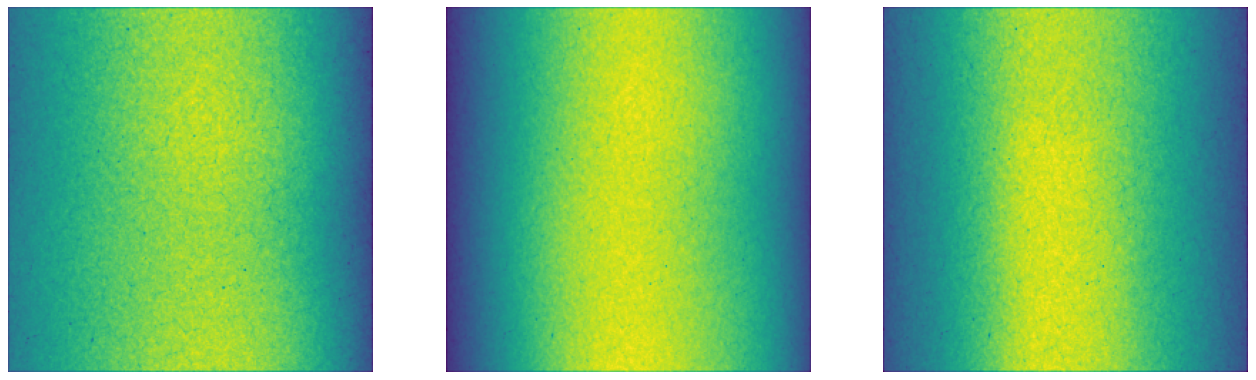

In [ ]:
# смотрим на тренировчные данные
plotExamples(Y_train, n_samp=3)

In [ ]:
# стандартизируем изображения
X_train_st, dataMean, dataStd = standart(X_train)
Y_train_st, _, _ = standart(Y_train, dataMean=dataMean, dataStd=dataStd)

Mean:  -3.438469e-07 Std:  1.0000001
Mean:  0.49594206 Std:  1.0479155


In [ ]:
#Mean:  -3.438469e-07 Std:  1.0000001

In [ ]:
# нормализуем изображения
X_train_norm = norm(X_train)
Y_train_norm= norm(Y_train)

In [ ]:
# обучаем модель
d_model = discriminator(image_shape)
g_model = prelearned_model
gan_model = gan(g_model, d_model, image_shape)

start1 = datetime.now() 

d_loss, g_loss = train(d_model, g_model, gan_model, X_train_norm, Y_train_norm, n_epochs=700, n_batch=128) 

stop1 = datetime.now()

execution_time = stop1-start1
print("Execution time is: ", execution_time)

>1/1400, d1[0.253] d2[1.084] g[2837.763]
>2/1400, d1[0.429] d2[0.574] g[2520.560]
>3/1400, d1[0.458] d2[0.510] g[2082.941]
>4/1400, d1[0.299] d2[0.414] g[1987.781]
>5/1400, d1[0.282] d2[0.222] g[1827.223]
>6/1400, d1[0.185] d2[0.181] g[1720.787]
>7/1400, d1[0.132] d2[0.124] g[1572.568]
>8/1400, d1[0.106] d2[0.074] g[1392.245]
>9/1400, d1[0.080] d2[0.054] g[1284.302]
>10/1400, d1[0.059] d2[0.048] g[1186.667]
>11/1400, d1[0.053] d2[0.053] g[1032.432]
>12/1400, d1[0.044] d2[0.067] g[1150.294]
>13/1400, d1[0.038] d2[0.029] g[898.330]
>14/1400, d1[0.034] d2[0.026] g[842.853]
>15/1400, d1[0.027] d2[0.025] g[752.745]
>16/1400, d1[0.022] d2[0.025] g[670.723]
>17/1400, d1[0.022] d2[0.025] g[539.985]
>18/1400, d1[0.018] d2[0.028] g[480.632]
>19/1400, d1[0.018] d2[0.024] g[393.294]
>20/1400, d1[0.022] d2[0.029] g[344.274]
>21/1400, d1[0.021] d2[0.036] g[278.607]
>22/1400, d1[0.047] d2[0.059] g[253.553]
>23/1400, d1[0.052] d2[0.101] g[267.960]
>24/1400, d1[0.173] d2[0.161] g[269.828]
>25/1400, d1[

In [ ]:
model_norm = load_model('model_001400.h5')
model_st = load_model('model_001200.h5')

In [ ]:
 y_pred_norm = model_norm.predict(X_train_norm)
 y_pred_st = model_st.predict(X_train_st)

# Эксперимент с жуком

In [ ]:
model = load_model('model_001200.h5')

In [ ]:
dset = dataUpload(DATA_PATH+'bug_exp.hdf5', IMG_WIGHT, IMG_HEIGHT, IMG_CHANNELS)

Выберите какие файлы загрузить: ['dark', 'data', 'empty']
data


In [ ]:
dset_old = dset
dset_new, _, _ = standart(dset, dataMean=dataMean, dataStd=dataStd)

Mean:  1.1415695 Std:  0.9276296


In [ ]:
y_pred = model.predict(dset_new)

In [ ]:
y_pred_ret = destandart(y_pred, dataMean, dataStd)

Mean:  2039.2817 Std:  699.4617


In [ ]:
Y = dataUpload(DATA_PATH+'bug_exp.hdf5', IMG_WIGHT, IMG_HEIGHT, IMG_CHANNELS)

Выберите какие файлы загрузить: ['dark', 'data', 'empty']
empty


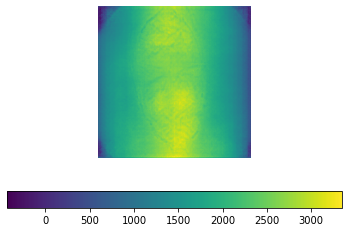

In [ ]:
plt.axis('off')
plt.imshow(y_pred_ret[10, :, :, 0])
plt.colorbar(orientation='horizontal')

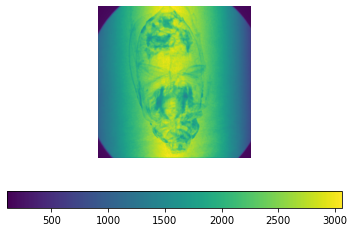

In [ ]:
plt.axis('off')
plt.imshow(dset[10, :, :, 0])
plt.colorbar(orientation='horizontal')

In [ ]:
gty_mean = np.zeros((IMG_WIGHT, IMG_HEIGHT))
n = len(Y)
for i in range(n):
  gty_mean += Y[i, :, :, 0]
gty_mean = gty_mean/n

In [ ]:
from PIL import Image

In [ ]:
frames_pred = []
frames_real = []

for i in range(len(dset_old)):
    img = Image.fromarray(dset[i, :, :, 0]/y_pred_ret[i, :, :, 0]*255)
    frames_pred.append(img)

    img = Image.fromarray(dset[i, :, :, 0]/gty_mean*255)
    frames_real.append(img)

frames_pred[0].save('bug_pred.gif', format='GIF', append_images=frames_pred[1:], save_all=True, duration=100, loop=0)
frames_real[0].save('bug_real.gif', format='GIF', append_images=frames_real[1:], save_all=True, duration=100, loop=0)

Конец эксперимента

In [ ]:
#возврат к достандартизированному состоянию
y_pred_ret = destandart(y_pred_st, dataMean, dataStd)
X_train_ret = destandart(X_train_st, dataMean, dataStd)
Y_train_ret = destandart(Y_train_st, dataMean, dataStd)

Mean:  1522.0182 Std:  710.03644
Mean:  1165.7954 Std:  679.2313
Mean:  1502.6556 Std:  711.77704


In [ ]:
#возврат к донормализованному состоянию
y_pred_ret = denorm(y_pred, bit=12)
X_train_ret = denorm(X_train, bit=12)
Y_train_ret = denorm(Y_train, bit=12)

In [ ]:
for i in range(200):
  plt.figure(figsize=(15, 15))#, dpi=80)

  plt.subplot(1, 5, 1)
  plt.axis('off')
  plt.imshow(X_train[i, :, :, 0], vmin = -2, vmax = 4)

  plt.subplot(1, 5, 2)
  plt.axis('off')
  plt.imshow(y_pred[i, :, :, 0], vmin = -2, vmax = 4)

  plt.subplot(1, 5, 3)
  plt.axis('off')
  plt.imshow(Y_train[i, :, :, 0], vmin = -2, vmax = 4)

  plt.subplot(1, 5, 4)
  plt.axis('off')
  plt.imshow(X_train[i, :, :, 0]/Y_train[i, :, :, 0], vmin = 0, vmax = 2)

  plt.subplot(1, 5, 5)
  plt.axis('off')
  plt.imshow(X_train[i, :, :, 0]/y_pred[i, :, :, 0], vmin = 0, vmax = 2)

  plt.show()

# Отрисовка лучших и худших по PSNR

In [ ]:
# X_train_return = X_train*dataStd+dataMean
# Y_train_return = Y_train*dataStd+dataMean
# y_pred_return = y_pred*dataStd+dataMean

X_train_return = X_train_ret
Y_train_return = Y_train_ret
y_pred_return = y_pred_ret

# Y_train_return[Y_train_return == 0] = 0.1
# y_pred_return[y_pred_return == 0] = 0.1
# X_train_return[X_train_return == 0] = 0.1

In [ ]:
ff_gt = np.zeros((len(X_train_ret), IMG_HEIGHT, IMG_WIGHT, IMG_CHANNELS), dtype=np.float32)
ff_norm = np.zeros((len(X_train_ret), IMG_HEIGHT, IMG_WIGHT, IMG_CHANNELS), dtype=np.float32)
ff_st = np.zeros((len(X_train_ret), IMG_HEIGHT, IMG_WIGHT, IMG_CHANNELS), dtype=np.float32)

for i in range(len(X_train_ret)):
  ff_gt[i] = X_train_ret[i]/Y_train_ret[i]
  ff_norm[i] = X_train_ret[i]/y_pred_ret_norm[i]
  ff_st[i] = X_train_ret[i]/y_pred_ret_st[i]

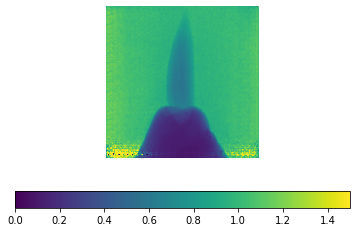

In [ ]:
plt.axis('off')
plt.imshow(ff_norm[10, :, :, 0], vmin=0, vmax=1.5)
plt.colorbar(orientation='horizontal')

In [ ]:
metr = []
for i in range(len(y_pred_return)):
  t = round(float(PSNR(Y_train_return[i, :, :, 0], y_pred_return[i, :, :, 0])), 2)
  metr.append((i, t))

In [ ]:
arr = sorted(metr, key=lambda x:x[1])

In [ ]:
print(arr[:5])

[(80, 0.34), (204, 0.41), (277, 0.49), (53, 0.54), (234, 0.62)]


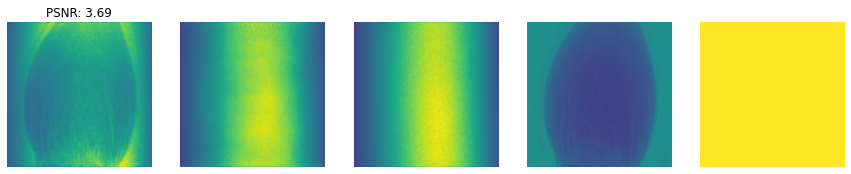

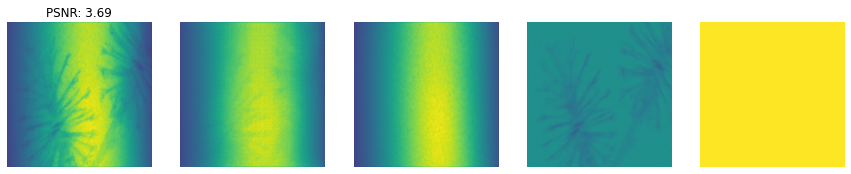

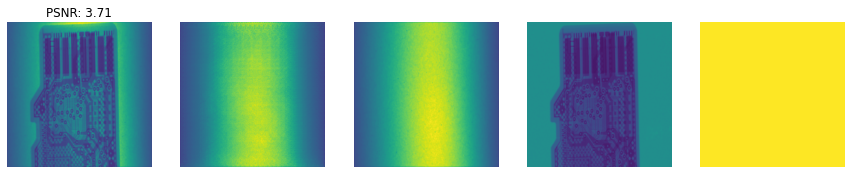

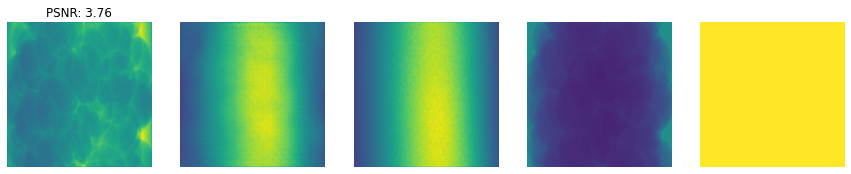

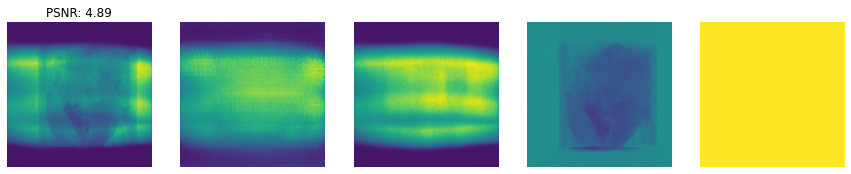

In [ ]:
for j in arr[-5:]:
  i = j[0]

  plt.figure(figsize=(15, 15))#, dpi=80)

  plt.subplot(1, 5, 1)
  plt.axis('off')
  plt.imshow(X_train_return[i, :, :, 0], vmin = 0)
  plt.title(f'PSNR: {j[1]}')

  plt.subplot(1, 5, 2)
  plt.axis('off')
  plt.imshow(y_pred_return[i, :, :, 0], vmin = 0)

  plt.subplot(1, 5, 3)
  plt.axis('off')
  plt.imshow(Y_train_return[i, :, :, 0], vmin = 0)

  plt.subplot(1, 5, 4)
  plt.axis('off')
  plt.imshow(X_train_return[i, :, :, 0]/Y_train_return[i, :, :, 0], vmin = 0, vmax = 2)

  plt.subplot(1, 5, 5)
  plt.axis('off')
  plt.imshow(X_train_return[i, :, :, 0]/y_pred_return[i, :, :, 0], vmin = 0, vmax = 2)

  plt.show()

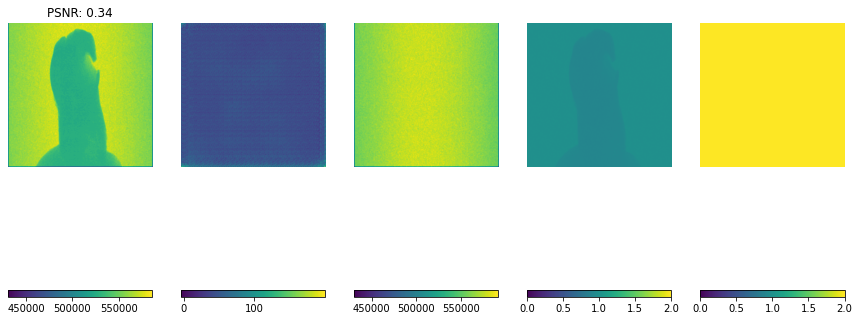

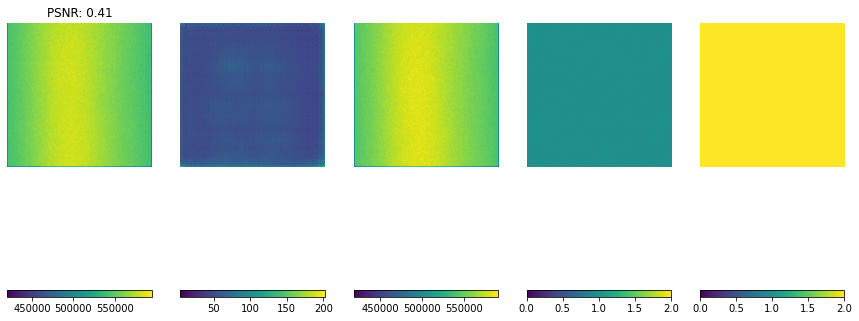

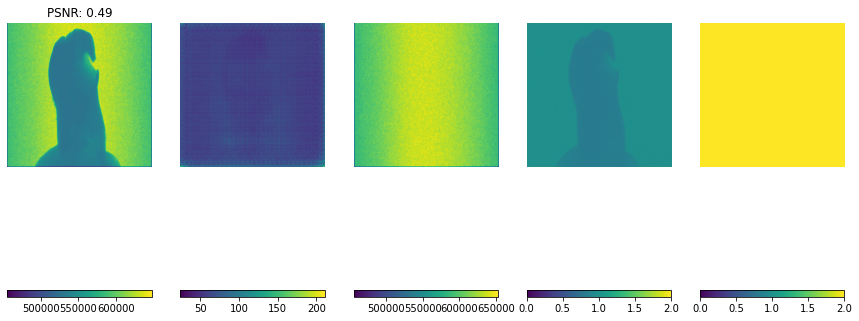

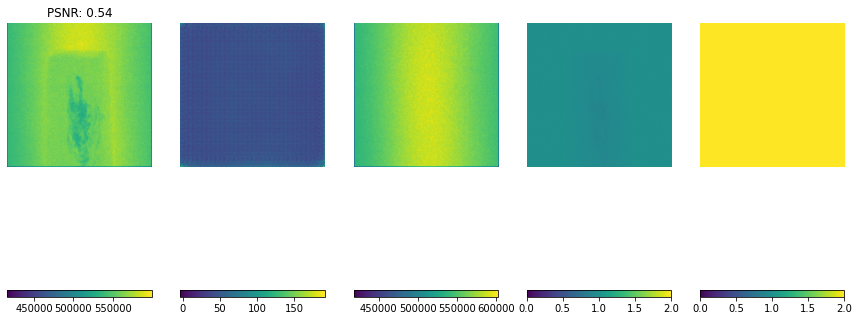

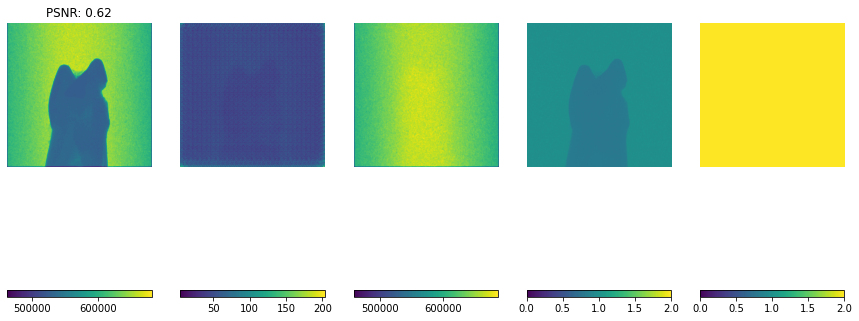

In [ ]:
for j in arr[:5]:
  i = j[0]

  plt.figure(figsize=(15, 15))#, dpi=80)

  plt.subplot(1, 5, 1)
  plt.axis('off')
  plt.imshow(X_train_return[i, :, :, 0])
  plt.title(f'PSNR: {j[1]}')
  plt.colorbar(orientation='horizontal')

  plt.subplot(1, 5, 2)
  plt.axis('off')
  plt.imshow(y_pred_return[i, :, :, 0])
  plt.colorbar(orientation='horizontal')

  plt.subplot(1, 5, 3)
  plt.axis('off')
  plt.imshow(Y_train_return[i, :, :, 0])
  plt.colorbar(orientation='horizontal')

  plt.subplot(1, 5, 4)
  plt.axis('off')
  plt.imshow(X_train_return[i, :, :, 0]/Y_train_return[i, :, :, 0], vmin = 0, vmax = 2)
  plt.colorbar(orientation='horizontal')

  plt.subplot(1, 5, 5)
  plt.axis('off')
  plt.imshow(X_train_return[i, :, :, 0]/y_pred_return[i, :, :, 0], vmin = 0, vmax = 2)
  plt.colorbar(orientation='horizontal')

  plt.show()

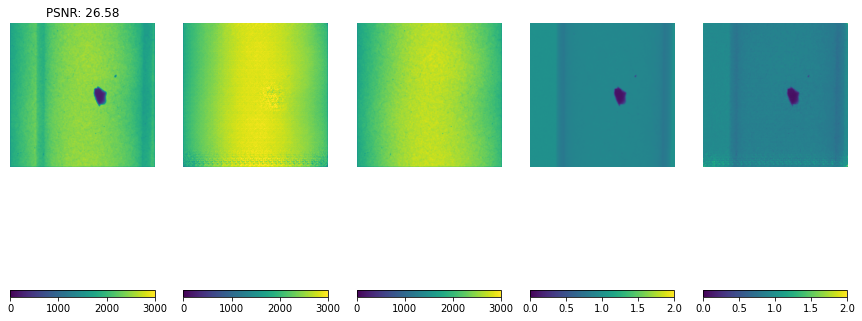

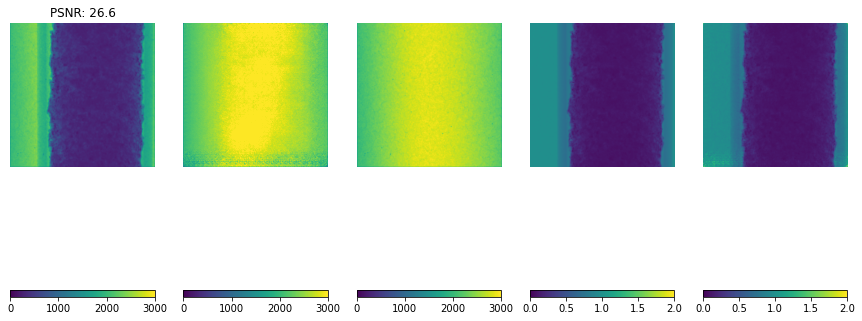

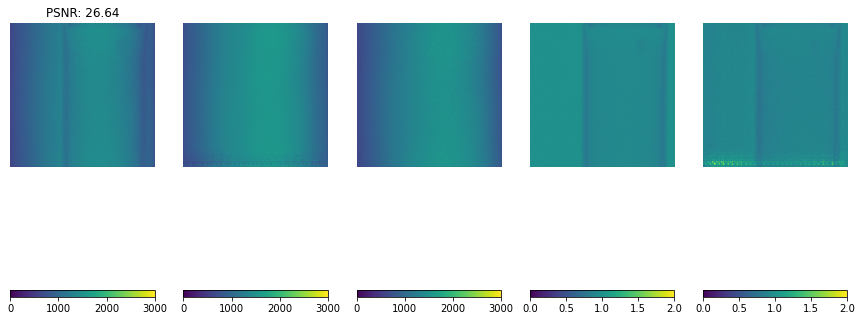

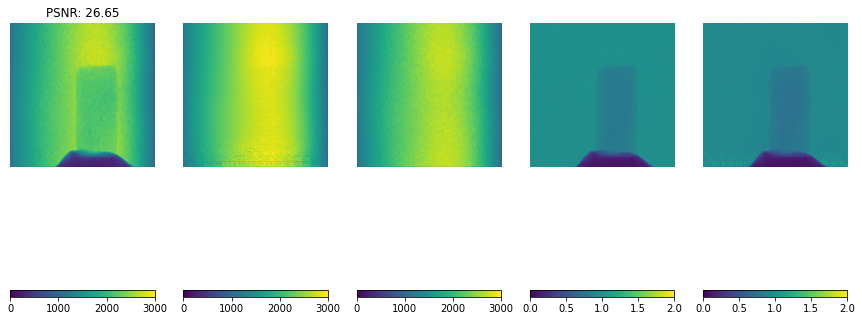

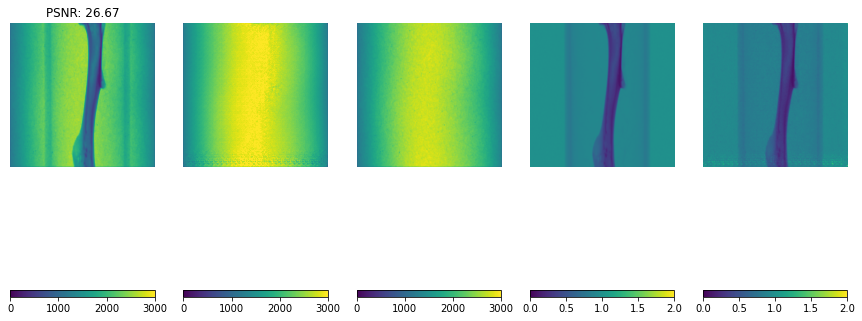

In [ ]:
for j in arr[180:185]:
  i = j[0]

  plt.figure(figsize=(15, 15))#, dpi=80)

  plt.subplot(1, 5, 1)
  plt.axis('off')
  plt.imshow(X_train_return[i, :, :, 0], vmin = 0, vmax = 3000)
  plt.title(f'PSNR: {j[1]}')
  plt.colorbar(orientation='horizontal')
  
  plt.subplot(1, 5, 2)
  plt.axis('off')
  plt.imshow(y_pred_return[i, :, :, 0], vmin = 0, vmax = 3000)
  plt.colorbar(orientation='horizontal')

  plt.subplot(1, 5, 3)
  plt.axis('off')
  plt.imshow(Y_train_return[i, :, :, 0], vmin = 0, vmax = 3000)
  plt.colorbar(orientation='horizontal')

  plt.subplot(1, 5, 4)
  plt.axis('off')
  plt.imshow(X_train_return[i, :, :, 0]/Y_train_return[i, :, :, 0], vmin = 0, vmax = 2)
  plt.colorbar(orientation='horizontal')

  plt.subplot(1, 5, 5)
  plt.axis('off')
  plt.imshow(X_train_return[i, :, :, 0]/y_pred_return[i, :, :, 0], vmin = 0, vmax = 2)
  plt.colorbar(orientation='horizontal')

  plt.show()